In [1]:
import math
from torch import empty
from torch import set_grad_enabled
from torch import no_grad
import numpy as np
import dlc_practical_prologue as prologue

set_grad_enabled(False)

In [2]:
class Module(object):
    def forward(self, *input):
        raise NotImplementedError
    def backward(self, *gradwrtoutput): 
        raise NotImplementedError
    def param(self): 
        return []

In [3]:
def xavier_normal_(tensor, fan_in , fan_out,gain = 1):
    std = gain * math.sqrt(2.0 / (fan_in + fan_out))
    with no_grad():
        return tensor.normal_(0, std)
def xavier_uniform_(tensor, fan_in , fan_out,gain = 1):
    a = gain * math.sqrt(6.0 / (fan_in + fan_out))
    with no_grad():
        return tensor.uniform_(-a, a)

In [4]:
class Parameters(Module):
    """
    Implement the fully connected layer module
    """
    def __init__(self,linear,gain=5.0/3):
        super().__init__()

        self.hidden_size = linear.hidden_size
        self.input_size = linear.input_size
        # Initialisation with Xavier methods
        self.weights=xavier_uniform_(empty(self.input_size, self.hidden_size),self.input_size,self.hidden_size,gain)#.uniform_(-1/math.sqrt(input_size),1/math.sqrt(input_size))#Weight
        self.biais=xavier_uniform_(empty(self.hidden_size),self.input_size,self.hidden_size,gain)#.uniform_(-1/math.sqrt(input_size),1/math.sqrt(input_size))#bias

        
    
    def sigma(self,x):
        out = 0
        if len(x.size())>1:#Processing for mini-batch
            one_matrix = empty(x.size(0),self.hidden_size).zero_().add(1) #we multiply the result with the batch size
            out = x.mm(self.weights)+self.biais.view(1,-1)*one_matrix #Could be optimize with broadcasting
        else : #single input
            #W*x + b
            out = self.weights.t().mv(x)+self.biais 
        return out 
    def dsigma(self,x):
        out = 0
        if len(x.size())>1:
            out = x.mm(self.weights.T)#matrix output (X (M_batch x N_input_size) * W (N input_size x hidden_size) = out (M_batch x hidden_size))
        else : 
            out = self.weights().mv(x)#vector output
        return out
    def param(self):
        return [self.weights,self.biais]
    def set_param(self,new_w,new_b):
        """
        Allow to update the parameters when we have done the optimize step calculation.
        """
        self.weights= new_w
        self.biais = new_b
    def backward(self, *gradwrtoutput):
        """"
        l(s2(a2(s1(a1(x)))))' = l'(s2(a2(s1(x))))(s2(a2(s1(x))))' = l'(s2(a2(s1(x))))(s2'(a2(s1(x))))a2'(s1(x))
        = l'(s2(a2(s1(x))))(s2'(a2(s1(x))))a2'(s1(x))s1'(a1(x))
        
        où s1(x) = s1(W_{n-1}( ... s_{1}( W_{1} x + b_{1} )+b_{n-2} )+ b_{n-1}) 
        
        dl_ds = l'(s(a(x)))
        
        ds_da = s'(a(x))
        
        dl_ds = l'(s(a(x)))(s'(a(x)))
        
        dl_dw = dl_ds * da_dw 
         
        dl_db = dl_ds * da_db
        
        """
        dl_ds = gradwrtoutput[0]
        
        #da_dw contient N element de H size 
        #dl_dw la variation de la perte par rapport au poids,
        #pour la données j du batch, 
        #dl_dw = [(da_dw)_j1 * dl_ds ,(da_dw)_j2 * dl_ds,...,(da_dw)_jh * dl_ds]
        #où dl_ds est un vecteur 
        
        
        dl_dx = self.dsigma(dl_ds)
        
        return dl_dx
        
    def forward(self, *input):
        return self.sigma(*input)
    
    
    def zero_grad(self):
        self.grad_w.zero_()
        self.grad_b.zero_()
        
  
        
    def get_grad(self):
        return [self.grad_w,self.grad_b]

In [5]:
class Linear(Module):
    """
    Implement the fully connected layer module
    """
    def __init__(self,input_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.input_size = input_size
  

### Activation Functions

In [6]:
class Activation(Module):
    """
    Implement activation layer tanh
    """
    def __init__(self,activation):
        super().__init__()
        self.ds_da=0
        self.s=0
        self.da_dw = 0
        self.sigma =activation.sigma
        if hasattr(activation,'dsigma') :
            self.dsigma=activation.dsigma
            
        else:  
            0
            #chercher la dérivé dsigma 
    
    
    def backward(self, *gradwrtoutput):
        """"
        l(s(w(x)))' = l'(s(g(x)))(s(g(x)))' = l'(s(g(x)))(s'(g(x)))g'(x)
        
        où a(x) = W_{n} (s_{n-1} (W_{n-1}( ... s_{1}( W_{1} x + b_{1} )+b_{n-2} )+ b_{n-1} ) + b_{n}
        
        dl_dx = l'(s(a(x)))
        
        ds_da = s'(a(x))
        
        dl_ds = l'(s(a(x)))(s'(a(x)))
        
        
        """
        
        dl_dx = gradwrtoutput[0]
        da_dw = self.da_dw
        #1ere itération : récupéeration de la dérivée du loss evalué à l'output du net
        #autre :  
    
        dl_ds = self.ds_da*dl_dx #avec dérivé évalué au point du forward 
        dl_dw =( da_dw.view(da_dw.size(0),da_dw.size(1),1).matmul(dl_ds.view(dl_ds.size(0),1,dl_ds.size(1))))
       
        
        return dl_ds,dl_dw
    def forward(self, *input):  
        self.da_dw,self.s = input
        self.ds_da = self.dsigma(self.s)#calcule de la dérivé évalué au point du forward qu'on stock pour le backward
        return self.sigma(self.s)

In [7]:
class Tanh( Module ) :
    def __init__(self):
        super().__init__()
        self.ds_da = 0
    def sigma(self,x):
        return x.tanh()
    def dsigma(self,x):
        return 4 * (x.exp() + x.mul(-1).exp()).pow(-2)


In [8]:
class Relu( Module ) :
    def __init__(self):
        super().__init__()
        self.ds_da = 0
    def sigma(self,x):
        return x.max(empty(x.size()).zero_())
    def dsigma(self,x):
        out = empty(x.size()).zero_()
        out[x>0]=1
        return out
    

### Loss functions

In [9]:
class Loss(Module):
    """
    Loss has a network and a loss. 
    It uses the "sigma" method of the loss function (MSE)
    """
    def __init__(self,loss,net):
        super().__init__()
        self.net = net
        self.loss = loss
        self.acc_loss=0
        self.nb_train_errors=0
        
    def sigma(self,x,y):
        return self.loss.sigma(x,y)
    
    def dsigma(self,x,y):
        return self.dloss.sigma(x,y)
    
    def assign(self, net):
        self.net = net 
    
    def predict(self,x,test_target):
        """"
        just to evaluate the prediction of the network on one mini-batch
        """
        
        return (test_target.argmax(1)!=x.argmax(1)).sum(),self.loss.sigma(x, test_target).sum()
            
        
    def backward(self,*gradwrtoutput):
        #This function call the forward method of the network for one mini-batch, and then the backward function of the network
        x = self.net.forward(self.net.train)
        
        #x has row of mini_batch size and column of linear output (before activation))
        #s has row of mini_batch size and column of activation function (after activation))   
        nb_train_errors,acc_loss=self.predict(x,self.net.train_target)
        self.nb_train_errors+=nb_train_errors
        self.acc_loss+=acc_loss
        dl_dx2 = self.loss.dsigma(x, self.net.train_target)
        self.net.backward(dl_dx2)

In [10]:
class MSE(Module):
    """
    Implement the loss function Mean Square Error
    """
    def __init__(self):
        super().__init__()       
    def sigma(self,x,y):      
        return (x - y).pow(2).sum()
    def dsigma(self,x,y):   
        return 2*(x - y)
    

### Optimizer

In [11]:
class SGD(Module):
    def __init__(self,net,lr):
        super().__init__()
        self.net = net
        self.lr = lr
    def sigma(self,param,grad):
        out=[]
        for i in range(len(param)):
            out.append(param[i] - self.lr * grad[i].sum(0) ) #en faisant que n(t,b) sot séquentielle
        return out
    def step(self):
        for i in range(len(net.param())):
            new_w,new_b=self.sigma(self.net.get_param(i),self.net.get_grad(i))
            net.set_param(i,new_w,new_b)




### net module

In [12]:
class Net(Module):
    def __init__(self):
        super().__init__()
        self.Parameters = [] #List of fully connected layers
        self.Activation = [] #List of activation functions
        self.dl_dw=0
        self.dl_db=0
        self.train = []
        self.train_target = []
        self.num_sample = -1
        self.num_parameters = 0
    def forward(self,*input):
        x=input[0]
        for i in range(len(self.Activation)):
            s = self.Parameters[i].forward(x)
            x = self.Activation[i].forward(x,s)
        return x

    def backward(self,*gradwrtoutput):
        """
        call by the Loss module for updating the weigths of the network
        """
        N=self.num_parameters
        dl_dx = gradwrtoutput[0]
        dl_ds,dl_dw = self.Activation[-1].backward(dl_dx)
        self.dl_dw[-1].add_(dl_dw)
        self.dl_db[-1].add_(dl_ds)

        for i in range(N-1,0,-1): #Backpropagate for each layer once we took care of the loss
            dl_dx = self.Parameters[i].backward(dl_ds)
            dl_ds,dl_dw = self.Activation[i-1].backward(dl_dx)
            self.dl_dw[i-1].add_(dl_dw)
            self.dl_db[i-1].add_(dl_ds)
            
            
            
    def param(self):
        return self.Parameters
    
    def init(self,new_Parameters,new_Activation):
        self.num_parameters= len(new_Parameters)
        self.Parameters= new_Parameters
        self.Activation = new_Activation

    def set_param(self,num_layer,new_w,new_b):
        self.Parameters[num_layer].set_param(new_w,new_b)
        
    def get_grad(self,num_layer):
        return [self.dl_dw[num_layer],self.dl_db[num_layer]]
    
    def get_param(self,num_layer):
        return self.Parameters[num_layer].param()
    
    def zero_grad(self):
        for dw in self.dl_dw:
            dw.zero_()
        for db in self.dl_db:
            db.zero_()
        

    def assign(self, train,train_target):
        
        if len(train_input.size())>1: #mini batch
            self.train = train
            self.train_target = train_target
            if train.size(0)!=self.num_sample:
                self.num_sample = train.size(0)
                self.dl_dw = [empty(self.num_sample,p.param()[0].size(0),p.param()[0].size(1)) for p in self.Parameters]
                self.dl_db = [empty(self.num_sample,p.param()[1].size(0)) for p in self.Parameters]
                   
        else : 
            self.num_sample = 1
            self.train = train
            self.train_target = train_target
           

        

In [13]:
class Sequential(Module):
    def __init__(self,*layers):
        super().__init__()
        self.layers = layers 
    def init_net(self):
        net = Net()
        new_Parameters=[]
        new_Activation=[]
        i = 0
        for k in range(len(self.layers)-1,-1,-1) : 
            if np.mod(i,2)==0:
                if type(self.layers[k])==type(Tanh()):
                    gain=5/3
                if type(self.layers[k])==type(Relu()):
                    gain=math.sqrt(2.0)
                new_Activation.insert(0,Activation(self.layers[k]))
                
            else : 
                
                new_Parameters.insert(0,Parameters(self.layers[k],gain))
            i=i+1
        net.init(new_Parameters,new_Activation)
        return net 

In [14]:
def one_hot(a):
    num_class = a.max()+1
    N=a.size(0)
    out = empty(N,num_class).zero_()
    for i in range(N):
        out[i][a[i]]=1 
    return out 
        

### Test Script

In [15]:
def generate_disc_set(nb):
    input = empty(nb, 2).uniform_(-1, 1)
    target = input.pow(2).sum(1).sub(2 / math.pi).sign().add(1).div(2).long()
    
    return input, one_hot(target)

In [16]:
from time import time
import matplotlib.pyplot as plt

nb_train_samples=1000
nb_test_samples=1000
nb_epochs = 1000
nb_hidden = 25
mini_batch_size = 500
eta = 1e-1 / nb_train_samples
epsilon = 1e-6


train_input, train_target = generate_disc_set(nb_train_samples)
test_input, test_target = generate_disc_set(nb_test_samples)

mean, std = train_input.mean(), train_input.std()

train_input.sub_(mean).div_(std)
test_input.sub_(mean).div_(std)


nb_classes = train_target.size(1)



net = Sequential(Linear (train_input.size(1),(nb_hidden)),Relu(),
                 Linear( nb_hidden,nb_hidden),Tanh(),
                 Linear( nb_hidden,nb_hidden),Relu(),
                 Linear( nb_hidden,nb_hidden),Relu(),
                 Linear( nb_hidden,nb_classes),Tanh()).init_net()

loss = Loss(MSE(),net)
optimizer= SGD(net,eta)


test_error = empty(nb_epochs).zero_()
train_error = empty(nb_epochs).zero_()
train_acc = empty(nb_epochs).zero_()



zeit = empty(nb_epochs,nb_train_samples).zero_()
for e in range(nb_epochs):
    i=0
    if e == 300:
        mini_batch_size = 200
    if e ==600:
        mini_batch_size = 250
    if e ==900:
        mini_batch_size = 200 
    for b in range(0, train_input.size(0), mini_batch_size):

    # Back-prop

        net.assign(train_input.narrow(0, b, mini_batch_size),train_target.narrow(0, b, mini_batch_size))
        net.zero_grad()
        tic = time()
        loss.backward()#This function call the forward method of the network then the backward for calculating the accumulators
        toc = time()
        zeit[e][i]=(toc-tic)
        i+=1
        # Gradient step with SGD
        optimizer.step()
    
    
    # Test error
    nb_test_errors,_=loss.predict(net.forward(test_input),test_target)   
    print('{:d} acc_train_loss {:.02f} acc_train_error {:.02f}% test_error {:.02f}%'
          .format(e,
                  loss.acc_loss.log(),
                  (100 * loss.nb_train_errors) / train_input.size(0),
                  (100 * nb_test_errors) / test_input.size(0)))
    
    test_error[e]=(100 * nb_test_errors) / test_input.size(0)
    train_error[e]=(100 * loss.nb_train_errors) / train_input.size(0)
    train_acc[e]=loss.acc_loss.log()
    loss.nb_train_errors  = 0
    loss.acc_loss=0


0 acc_train_loss 7.47 acc_train_error 47.70% test_error 38.60%
1 acc_train_loss 6.49 acc_train_error 40.20% test_error 42.60%
2 acc_train_loss 6.35 acc_train_error 39.90% test_error 41.70%
3 acc_train_loss 6.26 acc_train_error 39.00% test_error 39.80%
4 acc_train_loss 6.20 acc_train_error 37.10% test_error 35.10%
5 acc_train_loss 6.15 acc_train_error 34.10% test_error 33.00%
6 acc_train_loss 6.11 acc_train_error 32.70% test_error 30.40%
7 acc_train_loss 6.07 acc_train_error 31.70% test_error 25.90%
8 acc_train_loss 6.02 acc_train_error 30.30% test_error 22.20%
9 acc_train_loss 5.99 acc_train_error 28.10% test_error 20.30%
10 acc_train_loss 5.96 acc_train_error 27.00% test_error 20.30%
11 acc_train_loss 5.94 acc_train_error 26.10% test_error 20.80%
12 acc_train_loss 5.92 acc_train_error 26.90% test_error 21.40%
13 acc_train_loss 5.91 acc_train_error 27.30% test_error 21.80%
14 acc_train_loss 5.88 acc_train_error 26.00% test_error 20.60%
15 acc_train_loss 5.84 acc_train_error 24.90% test

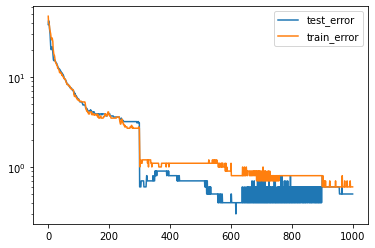

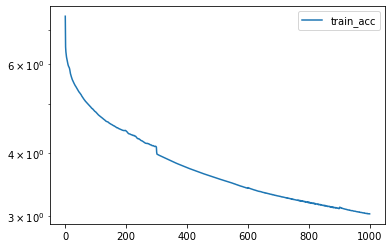

In [17]:
plt.figure()
plt.semilogy(test_error,label='test_error')
plt.semilogy(train_error,label='train_error')
plt.legend()
plt.show()
plt.figure()
plt.semilogy(train_acc,label='train_acc')
plt.legend()

In [18]:
from torch import save
from torch import load
from torch import cat
save(net,'./project_net_hybrid')

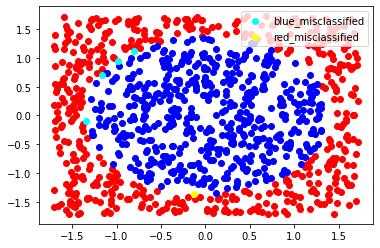

In [19]:
x = net.forward(test_input)
pred_class0 = (x.argmax(1)-1).nonzero()        
pred_class1 = x.argmax(1).nonzero()
class0 =(test_target.argmax(1)-1).nonzero()
class1 =(test_target.argmax(1)).nonzero()
combined = cat((pred_class0, class0))
uniques, counts = combined.unique(return_counts=True)
miss_classify0 = uniques[counts == 1]
well_classify0 = uniques[counts > 1]
combined = cat((pred_class1, class1))
uniques, counts = combined.unique(return_counts=True)
miss_classify1 = uniques[counts == 1]
well_classify1 = uniques[counts > 1]

combined = cat((miss_classify0.view(-1), class0.view(-1)))
uniques, counts = combined.unique(return_counts=True)
miss_classify0 = uniques[counts > 1]

combined = cat((miss_classify1.view(-1), class1.view(-1)))
uniques, counts = combined.unique(return_counts=True)
miss_classify1 = uniques[counts > 1]
plt.scatter(test_input[well_classify1].t()[0],test_input[well_classify1].t()[1],c='red')
plt.scatter(test_input[well_classify0].t()[0],test_input[well_classify0].t()[1],c='blue')
plt.scatter(test_input[miss_classify0].t()[0],test_input[miss_classify0].t()[1],c='cyan',label='blue_misclassified')
plt.scatter(test_input[miss_classify1].t()[0],test_input[miss_classify1].t()[1],c='yellow',label='red_misclassified')
plt.legend()


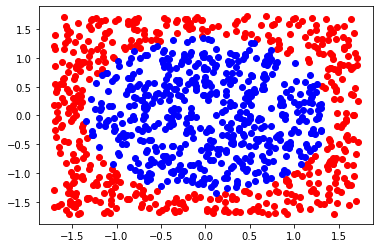

In [20]:
x = net.forward(test_input)
pred_class0 = (x.argmax(1)-1).nonzero()        
pred_class1 = x.argmax(1).nonzero()
class0 =(test_target.argmax(1)-1).nonzero().view(-1)
class1 =(test_target.argmax(1)).nonzero().view(-1)


combined = cat((miss_classify1.view(-1), class1.view(-1)))
uniques, counts = combined.unique(return_counts=True)
miss_classify1 = uniques[counts > 1]
plt.scatter(test_input[class1].t()[0],test_input[class1].t()[1],c='red')
plt.scatter(test_input[class0].t()[0],test_input[class0].t()[1],c='blue')



In [21]:
print('moyenne des temps par backward : ',zeit.mean())
print('temps d entrainement totale : ', zeit.sum())

moyenne des temps par backward :  tensor(2.2353e-05)
temps d entrainement totale :  tensor(22.3535)
